In [2]:
import pandas as pd

from utils.utils import load_data, remove_zero_features, load_confounders, standardize, generate_label_stats
from utils.plot_utils import aggregate_diagnoses, plot_diagnosis_frequency, plot_diagnosis_prevalence
from utils.plot_utils import plot_demographics, plot_feature_confounder_relation
from utils.plot_utils_umap import plot_umap_combined

In [2]:
# Load data for classification task
subject_data, features, diagnoses = load_data('classification')

In [3]:
C = load_confounders(subject_data, case='raw')
D = diagnoses.iloc[:,1:]

In [4]:
# Remove zero features
F = remove_zero_features(features.iloc[:,1:])
# Standardize
X = standardize(F)
print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")
# Remove ID column
Y = D
print(f"Number of labels: {Y.shape[1]}")

Number of samples: 2815
Number of features: 922
Number of labels: 13


# 1. Demographics

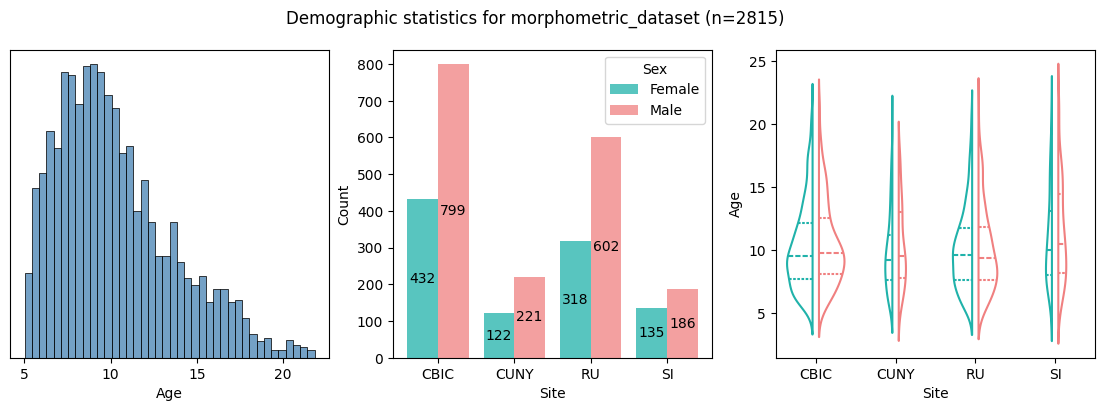

In [5]:
plot_demographics(C, 'morphometric_dataset')

# 2. Diagnostic labels

## 2.1. Label statistics (for individual labels)

In [6]:
df = aggregate_diagnoses(C, D)

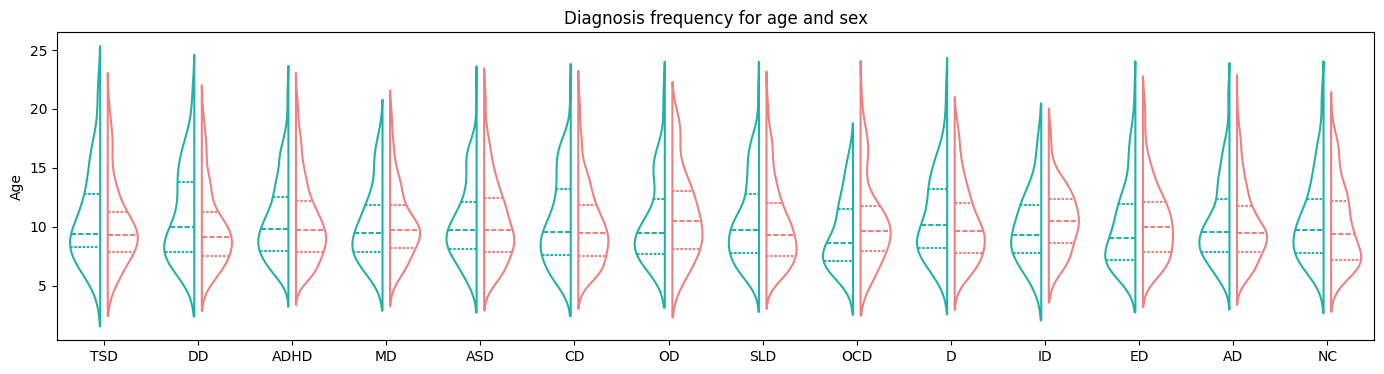

In [7]:
plot_diagnosis_frequency(df, 'morphometric_dataset')

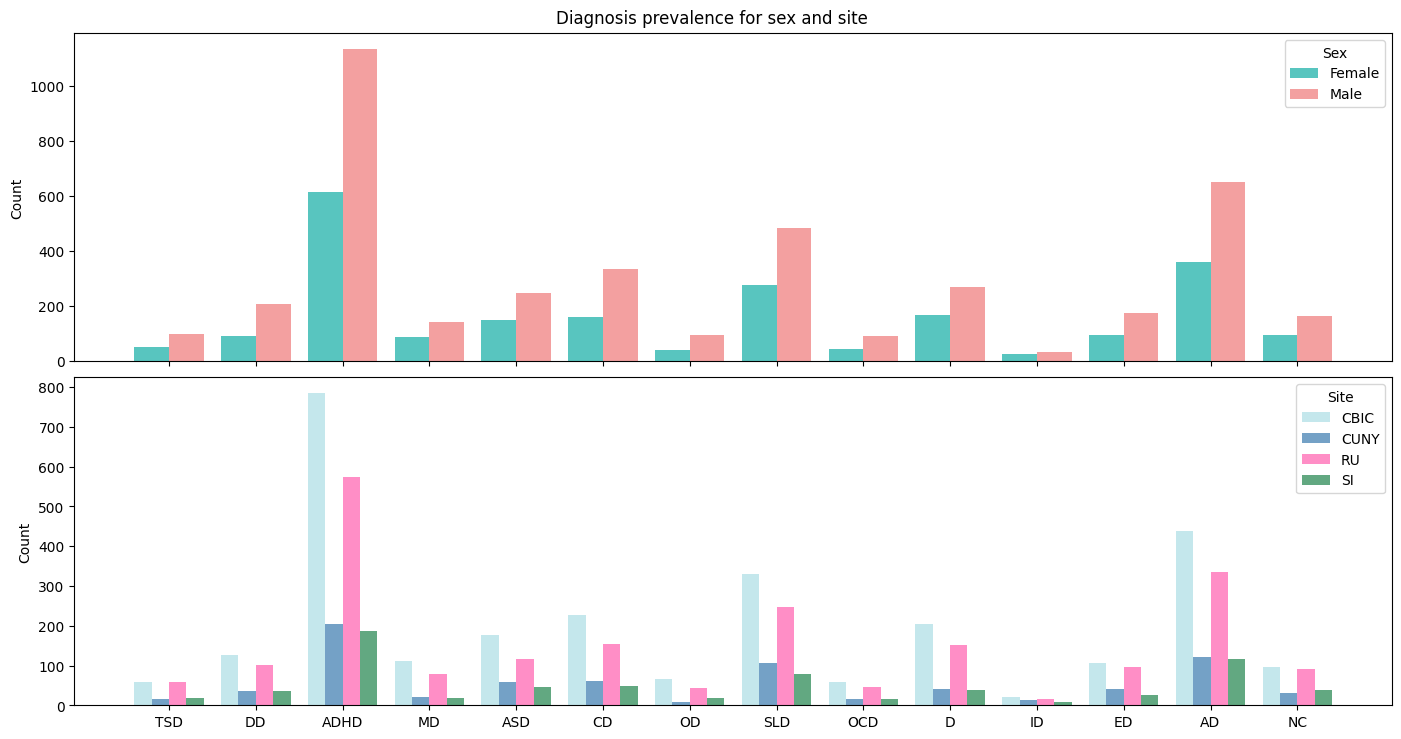

In [8]:
plot_diagnosis_prevalence(df, 'morphometric_dataset')

In [9]:
stats, mean_ir = generate_label_stats(D, mean_ir=True)
print(f"Mean imbalance ratio: {mean_ir:.2f}")
stats

Mean imbalance ratio: 8.00


,Absolute frequency,Relative frequency,Imbalance ratio
Trauma_And_Stress_RelatedDisorders,152,0.053996,11.519737
DepressiveDisorders,300,0.106572,5.836667
Attention_Deficit_HyperactivityDisorder,1751,0.622025,1.000000
MotorDisorder,229,0.081350,7.646288
AutismSpectrumDisorder,398,0.141385,4.399497
CommunicationDisorder,493,0.175133,3.551724
OtherDisorders,135,0.047957,12.970370
SpecificLearningDisorder,761,0.270337,2.300920
Obsessive_Compulsive_And_RelatedDisorders,137,0.048668,12.781022
Disruptive,436,0.154885,4.016055


## 2.2. Set statistics (for label sets)
A label set with cardinality greater 1 is a case of comorbidity

In [10]:
print(f"Number of uniqe lable sets: {D.apply(tuple, axis=1).nunique()}")
print(f"Mean set cardinality: {D.sum(axis=1).mean():.2f}")

Number of uniqe lable sets: 396
Mean set cardinality: 2.18


In [11]:
head_size = 10
print(f"{head_size} most frequent label sets:")
combinations = D.apply(lambda x: tuple(x), axis=1).value_counts()
combinations.head(head_size)

10 most frequent label sets:


(0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)    316
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)    260
(0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1)    116
(0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0)    109
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1)    100
(0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0)    100
(0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0)     83
(0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0)     68
(0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1)     52
(0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0)     48
Name: count, dtype: int64

In [12]:
print("Frequency of sets with cardinality 1 (occurence of one single disorder):")
combinations = D.apply(lambda x: tuple(x), axis=1).value_counts()
combinations = combinations[combinations.index.map(lambda x: sum(x) == 1)]
combinations

Frequency of sets with cardinality 1 (occurence of one single disorder):


(0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)    316
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1)    100
(0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0)    100
(0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0)     48
(0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0)     24
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0)     23
(0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)     22
(1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)     22
(0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0)     17
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0)     15
(0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0)     14
(0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0)      9
(0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0)      7
Name: count, dtype: int64

## 2.3. Low-dimensional representation
Project labels to a lower-dimensional space using UMAP (embedding method)

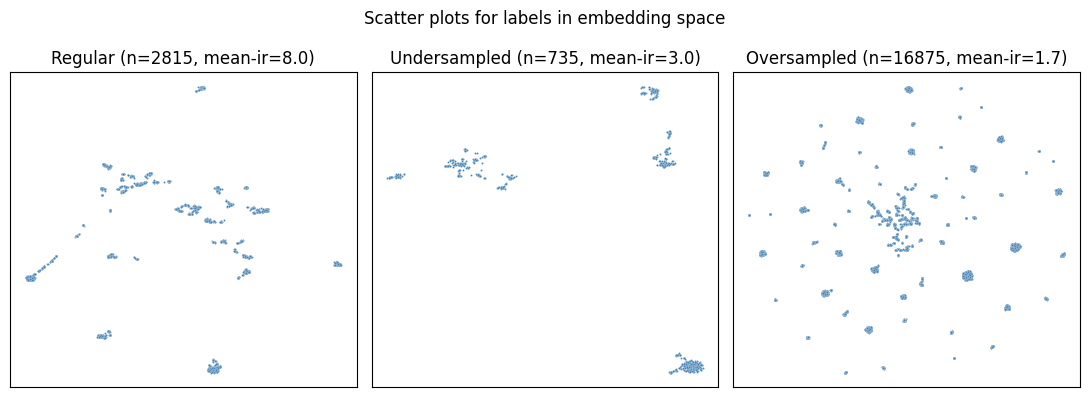

In [13]:
plot_umap_combined(X, Y, 'morphometric_dataset')

# 3. Morphometric features
Relationship between eTIV and confounding variables (age, sex)

In [14]:
F = features.iloc[:,1:]
f = pd.DataFrame()
f['TIV'] = F['global_estimatedtotalintracranialvol']
f['TIV'] = f['TIV']/1e6
df = pd.concat([f,C], axis=1)

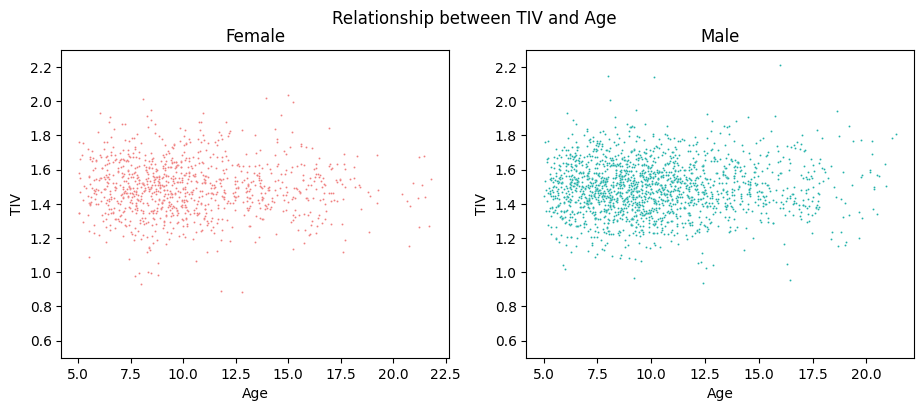

In [15]:
plot_feature_confounder_relation(df, 'TIV', 'Age', 'Sex', ['Female', 'Male'])

# 4. Brain images

In [19]:
# Load data for classification task
subject_data, _, diagnoses = load_data('classification_t1')

In [20]:
C = load_confounders(subject_data, case='raw')
D = diagnoses.iloc[:,1:]

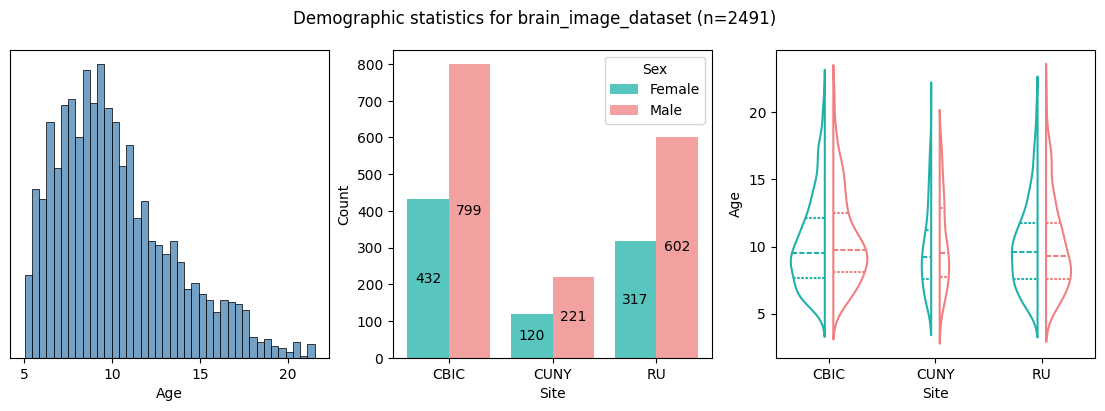

In [21]:
plot_demographics(C, 'brain_image_dataset')

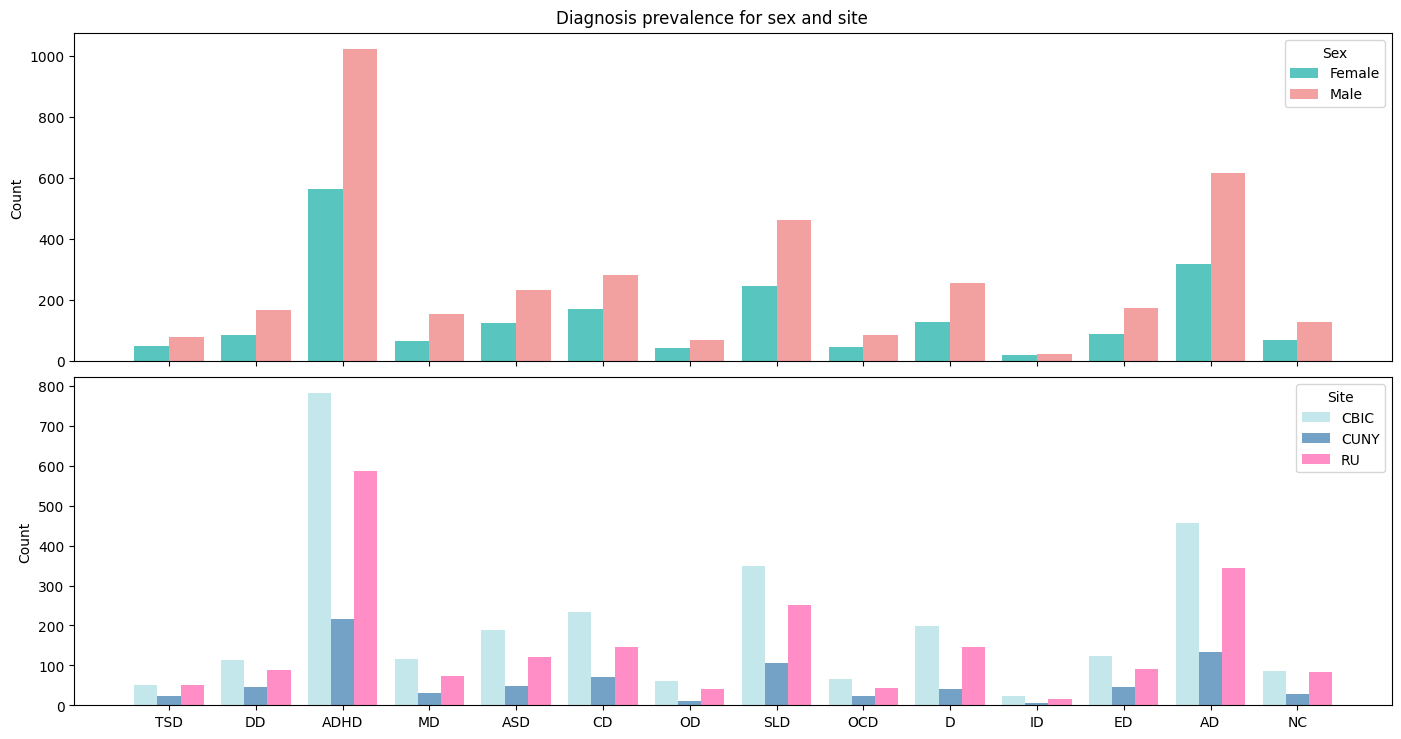

In [22]:
df = aggregate_diagnoses(C, D)
plot_diagnosis_prevalence(df, 'brain_image_dataset')